# Step 4

In [152]:
import pydot
import matplotlib.pyplot as plt
import time
import math
import random
import numpy as np
from scipy.special import comb

In [153]:
%run "Step3.ipynb"

## Plot the graph with random nodes' positions

In [154]:
def random_plot(file,size=15,plot='Yes'):
    nodes,edges = get_data(file)[2],get_data(file)[3]
    node_positions = {node:(int(random.uniform(0, size)),int(random.uniform(0, size))) for node in nodes}
    
    if plot == 'Yes':
        plt.figure(figsize=(size, size))
        for node, pos in node_positions.items():
            plt.scatter(pos[0], pos[1], color='green', s=200, marker='o', zorder =2)  
            plt.text(pos[0], pos[1], str(node), fontsize=10, ha='center', va='center')

        for edge in edges:
            start_coord = np.array(node_positions[edge[0]])
            end_node_center = np.array(node_positions[edge[1]])
            direction = end_node_center - start_coord
            direction_normalized = direction / np.linalg.norm(direction)
            end_coord = end_node_center - 0.4 * direction_normalized
            plt.arrow(*start_coord,*(end_coord - start_coord),head_width=0.15,head_length=0.15,fc='blue',ec='blue',zorder=1)
        plt.axis('off')
        plt.show()
    return node_positions

#random_plot('smallnet.dot',plot='Yes')

In [ ]:
def get_layer_assignment(file):
    layers =  layer_assignment(file)[0]
    node_positions = {node:(layers.index(layer),layer.index(node)) for layer in layers for node in layer}
    return node_positions

## Resolve Cycles

In [155]:
def child_nodes(edges,node):  #node_child_count, node_childs
    '''Returns the count of child nodes [0] and a list of them [1] of a specific node
    ''' 
    node_child_count = 0
    node_childs = []
    for edge in edges:
        if type(edges)==pydot.core.Edge:
            source = edge.get_source()
            destination = edge.get_destination()
        else:
            source = edge[0]
            destination = edge[1]
        if source == node:
            node_child_count += 1 
            node_childs.append(destination) 
    return node_child_count, node_childs

def parent_nodes(edges,node): #node_parent_count, node_parents O()
    '''Returns the count of parent nodes [0] and a list of them [1] of a specific node
    '''
    node_parent_count = 0
    node_parents = []
    #print(edges)
    for edge in edges:
        if isinstance(edge, pydot.core.Edge):
            source = edge.get_source()
            destination = edge.get_destination()
        else:
            source = edge[0]
            destination = edge[1]
        if destination == node:
            node_parent_count += 1 
            node_parents.append(source)
    return node_parent_count, node_parents

def sink_node(edges,node): #T or F: no outgoing edges
    '''Returns whether a node is a sink node considering a certain list of edges. 
    Being a sink nodes means that it doesnt have any outgoing edges
    '''
    return child_nodes(edges,node)[0] == 0

def source_node(edges,node): #T or F: no incoming edges 
    '''Returns whether a node is a source node considering a certain list of edges. 
    Being a source nodes means that it doesnt have any incoming edges'''
    return parent_nodes(edges,node)[0] == 0

def heuristic(file): #invert: list of edges tp be inverted
    '''Returns a list with the edges that need to be reversed to eliminate cycles
    '''
    node_list, edge_list = get_data(file)[2], get_data(file)[3] #O(V^2)
    V = node_list
    e = edge_list
    A = set()
    invert = []
    sink_nodes = [node for node in V if sink_node(e, node) == True] #no outgoing
    source_nodes = [node for node in V if source_node(e, node) == True] #no incoming
    isolated_nodes = [node for node in V if source_node(e, node) == True and sink_node(e, node) == True]
    
    while V != []:
        sink_nodes = [node for node in V if sink_node(e, node) == True]
        while sink_nodes != []:
            V.remove(sink_nodes[0])
            parents = parent_nodes(e,sink_nodes[0])[1]
            for parent in parents:
                edge = (parent,sink_nodes[0])
                A.add(edge)
                e.remove(edge)
            sink_nodes = [node for node in V if sink_node(e, node) == True]
        
        isolated_nodes = [node for node in V if source_node(e, node) == True and sink_node(e, node) == True]
        for node in isolated_nodes:
            V.remove(node)

        source_nodes = [node for node in V if source_node(e, node) == True] #no incoming
        while source_nodes != []:
            V.remove(source_nodes[0])
            childs = child_nodes(e,source_nodes[0])[1]
            for child in childs:
                edge = (source_nodes[0],child)
                A.add(edge)
                e.remove(edge)
            source_nodes = [node for node in V if source_node(e, node) == True] #no incoming
        if V!=[]:
            maximal = max([(v,child_nodes(e,v)[0]-parent_nodes(e,v)[0]) for v in V],key=lambda x: x[1])
            childs = child_nodes(e,maximal[0])[1]
            
            for child in childs:
                edge = (maximal[0],child)
                A.add(edge)
                e.remove(edge)
            parents = parent_nodes(e,maximal[0])[1]
            for parent in parents:
                edge = (parent,maximal[0])
                invert.append(edge)
                e.remove(edge)
            V.remove(maximal[0])
    return invert


In [156]:
def acyclic_graph(file,new_file): #new file with the acyclic graph
    '''Checks whether the graph inside a given file has cycles, and if so, it eliminates them and 
    creates a new file with the acyclic graph.
    '''
    invert = heuristic(file)
    node_list, edge_list, weights = get_data(file)[2], get_data(file)[3], get_data(file)[4]
    if invert !=[]:
        for edge in invert:
            edge_list.remove(edge)
            edge_list.append((edge[1],edge[0]))
            if weights != {}:
                weight = weights[edge]
                del weights[edge]
                weights[(edge[1],edge[0])] = weight
        return create_pydot_graph(node_list, edge_list, new_file,weights)
    return create_pydot_graph(node_list, edge_list, new_file,weights)

In [157]:
def plot_no_cycles(file,size=15,plot_original='Yes'):
    '''Function that plots the graph inside the .dot file, with default size set to 20, with random nodes positions
    and NO cycles, with reversed edges in red. If plot_original='Yes' it also plots the original graph, possibly with
    cycles in the strucure.
    '''
    edges = get_data(file)[3]
    node_positions = random_plot(file,plot=plot_original)
    invert = heuristic(file)
    plt.figure(figsize=(size, size))
    for node, pos in node_positions.items():
        plt.scatter(pos[0], pos[1], color='green', s=200, marker='o', zorder =2)  # Use marker='o' for circle markers
        plt.text(pos[0], pos[1], str(node), fontsize=10, ha='center', va='center')

    for edge in edges:
        new_edge = edge
        if edge in invert:
            new_edge = (edge[1],edge[0])
        
        start_coord = np.array(node_positions[new_edge[0]])
        end_node_center = np.array(node_positions[new_edge[1]])
        direction = end_node_center - start_coord
        direction_normalized = direction / np.linalg.norm(direction)
        end_coord = end_node_center - 0.4 * direction_normalized
        
        if edge not in invert:
            plt.arrow(*start_coord,*(end_coord - start_coord),head_width=0.15,head_length=0.15,fc='blue',ec='blue',zorder=1)
        else:
            plt.arrow(*start_coord,*(end_coord - start_coord),head_width=0.15, head_length=0.15,fc='red',ec='red',zorder=1)
    plt.axis('off')
    plt.show()

## Layer Assignment

In [158]:
def get_edges(edges, node): #edge_list: where node is the source
    '''Return a list with all the outgoing edges of a node.
    '''
    edge_list = []
    for edge in edges:
        source = edge[0]
        dest = edge[1]
        if source == node:
            edge_list.append(dest)
    return edge_list

def get_layer_pos(matrix, element): #layer, pos: which layer and pos inside the layer for a element
    '''Returns the layer and the position inside the layer of a certain element inside a matrix [[],[],[],...]
    '''
    for layer, row in enumerate(matrix):
        for pos, value in enumerate(row):
            if value == element:
                return layer, pos 
    return None

def dummy(layers,edges): #layers,new_edges: layers and edges with the needed dummy nodes
    new_edges = edges
    layers_dict = {}
    for i,item in enumerate(layers):
        layers_dict[i] = item

    for layer in layers_dict:
        for node in layers_dict[layer]:
            for dest in get_edges(edges, node):
                step = 1
                while dest not in layers_dict[layer + step] :
                    layers[layer+step].append(str('l'+str(layer+step)+'_'+node+'_'+dest))
                    step += 1

    dummies = [node for layer in layers for node in layer if node[0]=='l']
    max_layer = {dummy.split('_',1)[1]:get_layer_pos(layers,dummy.split('_')[2])[0] for dummy in dummies} #{'2_1': 3, '7_8': 3, '12_9': 2, '12_10': 2, '4_8': 3, '5_8': 3}
    min_layer = {dummy.split('_',1)[1]:get_layer_pos(layers,dummy.split('_')[1])[0] for dummy in dummies} #{'2_1': 0, '7_8': 0, '12_9': 0, '12_10': 0, '4_8': 1, '5_8': 1}

    for node in dummies:
        layer = int(node.split('_',1)[0][1:])
        edge_ish = node.split('_',1)[1]
        #source node -> first dummy
        if layer == int(1+min_layer[edge_ish]):
            new_edges.append((node.split('_')[1],node)) 
        #last dummy -> dest
        if layer == int(max_layer[edge_ish]-1): 
            new_edges.append((node,node.split('_')[2])) 
        #dummy -> dummy
        if layer > int(1+min_layer[edge_ish]):
            source = str('l'+str(int(layer-1))+'_'+edge_ish) 
            new_edges.append((source,node))
        
    for edge in max_layer:
        new_edges.remove((edge.split('_')[0], edge.split('_')[1])) #original source,final dest
    return layers,new_edges


In [159]:
def layer_assignment(file): #layers, edges: perfomrs layer assignment
    '''Layer assignment with heigh Optimization. Returns a list of lists with the layers and a list of the edges,
    taking into account the possible existance of dummy nodes
    '''
    new_file_name = str(file.split('.')[0]+'_acyc.dot')
    acyclic_graph(file,new_file_name)

    node_list, edge_list = get_data(new_file_name)[2], get_data(new_file_name)[3]
    layers = []
    S = [node for node in node_list if source_node(edge_list,node) == True]

    e = edge_list
    while S != []:
        layers.append(S)
        del_edges = []
        for node in S:
            new_edges = [edge for edge in e if edge[0]==node]
            for edge in new_edges:
                del_edges.append(edge)
        for edge in del_edges:
            e.remove(edge)
        node_list = [node for node in node_list if node not in S]
        S = [node for node in node_list if source_node(e,node) == True]

    final_layers = dummy(layers,get_data(new_file_name)[3])
    return final_layers[0],final_layers[1] #layers, edges



In [160]:
def f_dummy_paths(file): #list [source,dummy1,dummy2,...,dest] returns a dic with {source:[dummy1,dummy2,...,dest]}
    path = layer_assignment(file)[1] #edges
    #print('path',path)
    nodes_with_path = {}
    for source,dest in path:
        if not source.startswith('l'):
            final_destination = dest.split('_')[-1]
            if dest.startswith('l'):
                nodes_with_path[str(source + '_'+ final_destination)] = [dest]  
                
        else:
            if not dest.startswith('l'):
                nodes_with_path[str(source.split('_',1)[1])] += [dest] 

            else:
                nodes_with_path[str(source.split('_',1)[1])] += [dest]
    sorted_nodes_dict = {key: sorted(value, key=lambda source: (source.startswith('l'), source), reverse=False) for key, value in nodes_with_path.items()}
    
    return  [[source,nodes[1:],nodes[0]] for source,nodes in sorted_nodes_dict.items()],sorted_nodes_dict

def dummy_edges(file):
    dummy_path = f_dummy_paths(file)[1]
    ans = {}
    for source,dummies in dummy_path.items():
        ans[source] = [(source.split('_')[0],dummies[1])]
        for i in range(2,len(dummies)):
            ans[source].append((dummies[i-1],dummies[i]))
        ans[source].append((dummies[-1],dummies[0]))
    return ans

def find_inverted(file):
    d_dummies = f_dummy_paths(file)[1]
    #print(d_dummies)
    to_invert = heuristic(file)
    #print(to_invert)
    l_inverted = [(node[1],node[0])for node in to_invert]
    #print(l_inverted)
    catched = []
    for inverted in l_inverted:
        if str(inverted[0]+'_'+inverted[1]) in d_dummies.keys():
            source_node = inverted[0]
            #print(source_node)
            dest_node = inverted[1]
            catched.append((source_node,d_dummies[str(inverted[0]+'_'+inverted[1])][1]))
            for i in range(1,len(d_dummies[str(inverted[0]+'_'+inverted[1])][1:])):
                catched.append((d_dummies[str(inverted[0]+'_'+inverted[1])][i],d_dummies[str(inverted[0]+'_'+inverted[1])][i+1]))
            catched.append((d_dummies[str(inverted[0]+'_'+inverted[1])][-1],dest_node))
    return catched

In [161]:
def plot_layer_assignment(file, nodes={},dif_color='red'): 
    layers, edges = layer_assignment(file)[0], layer_assignment(file)[1]
    inverted = find_inverted(file)
    if nodes == {}:
        nodes = {}
        for i, layer in enumerate(layers):
            for j, node in enumerate(layer):
                nodes[node] = (j, i)
    size = len(get_data(file)[2])
    plt.figure(figsize=(size, size))         

    for node, coord in nodes.items():
        color = 'grey' if node.startswith('l') else 'green'
        plt.plot(*coord, marker='o', markersize=15, linestyle='', label='', zorder=2, color=color)  
        if not node.startswith('l'):
            plt.text(*coord, node, ha='center', va='center', fontsize=8, color='black', fontweight='bold')

    for edge in edges:
        # start_coord = np.array(nodes[edge[0]])
        # end_node_center = np.array(nodes[edge[1]])
        # direction = end_node_center - start_coord
        # direction_normalized = direction / np.linalg.norm(direction)
        # end_coord = end_node_center - 0.2 * direction_normalized

        # plt.arrow(*start_coord, *(end_coord - start_coord), head_width=0.06, head_length=0.06, fc='blue', ec='blue', zorder=1)

        if (edge[0].startswith('l') and not(edge[1].startswith('l'))) or (not(edge[0].startswith('l') or edge[1].startswith('l'))):
                    start_coord = np.array(nodes[edge[0]])
                    end_node_center = np.array(nodes[edge[1]])
                    direction = end_node_center - start_coord
                    direction_normalized = direction / np.linalg.norm(direction)
                    end_coord = end_node_center - 0.25 * direction_normalized
                    if edge in inverted:
                        plt.arrow(*start_coord, *(end_coord - start_coord), head_width=0.06, head_length=0.06, fc=dif_color, ec=dif_color, zorder=1)
                    else:
                        plt.arrow(*start_coord, *(end_coord - start_coord), head_width=0.06, head_length=0.06, fc='blue', ec='blue', zorder=1)
                
                # edges
        else:
            start_coord = np.array(nodes[edge[0]])
            end_node_center = np.array(nodes[edge[1]])
            if edge in inverted:
                plt.plot([start_coord[0], end_node_center[0]], [start_coord[1], end_node_center[1]], color=dif_color, linestyle='-', zorder=1)
            else:
                plt.plot([start_coord[0], end_node_center[0]], [start_coord[1], end_node_center[1]], color='blue', linestyle='-', zorder=1)

    plt.axis('off')
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().tick_params(axis='both', which='both', bottom=False, left=False)
    plt.gca().set_yticklabels([])
    plt.gca().set_xticklabels([])
    plt.gca().yaxis.grid(True)
    plt.show()


## Cross Minimization

In [162]:
def c_uv(u,v,edges,layer): #ans: integer representing the # crossing edges between u and v
    '''u and v are nodes from layer i+1, and we want to see the number of crossing when we look at they're parents
    in layer i
    '''
    u_parents = [(parent,layer.index(parent)) for parent in layer if parent in parent_nodes(edges,u)[1]]
    v_parents = [(parent,layer.index(parent)) for parent in layer if parent in parent_nodes(edges,v)[1]]
    ans = 0
    for u_parent in u_parents:
        for v_parent in v_parents:
            if u_parent[0] != v_parent[0] and u_parent[1] > v_parent[1]:
                ans += 1
    return ans


def cr(edges,layer1,layer2): #ans: total number of crossing between layer1 and layer2
    '''Returns the total number of crossing between layer1 and layer2
    '''
    ans = 0
    for u in layer2:#1
        for v in layer2:#1
            if layer2.index(v)>layer2.index(u):
                ans+= c_uv(u,v,edges,layer1)
    return ans

def bary(node,edges,layers,layer): #int: value for the barycenter for a node in a layer
    '''Returns the value of the barycenter heuristic for a specific node located in a specific layer.
    This version only sums the orders
    '''
    ans = 0
    parents = parent_nodes(edges,node)[1]
    childs = child_nodes(edges,node)[1]

    for parent in parents:
        ans+= int(layers[layer-1].index(parent))
    
    den = len(parents)+len(childs)
    return ans/den

def median(node, edges,layers,layer): #int: the order a node should have in a layer
    '''Returns the value of the median heuristic for a specific node located in a specific layer
    '''
    ans = 0
    neighbours = parent_nodes(edges,node)[1]
    coordinates = [layers[layer-1].index(neighbour) for neighbour in neighbours]
    o = sorted(coordinates)
    if neighbours != []:
        ans = o[len(o)//2] if len(o)%2 !=0 else o[len(o)//2-1]
    return ans

In [163]:
def it_cross_min(file, heur='bary',ite = 0): #final_layers[minimum],minimum
    '''Performs iterative crossing minimization on graph located in a file based on a given heuristic.
    Returns the layer with the minimum number of crossing and the minimum number of crossings.
    '''
    layers, edges = layer_assignment(file)[0], layer_assignment(file)[1]
    initial_crs = 0
    for i in range(1, len(layers)):
        initial_crs += cr(edges, layers[i-1], layers[i])
    final_layers = {}
    max_it = 100

    if ite == 0:
        ite = len(layers)**3

    if heur == 'bary':
        crs = []
        #number of iterations
        for j in range(ite):
            old_layers = layers[:]
            new_layers = []
            crs.append([])
            
            it = 0
            while new_layers != old_layers and it < max_it:
                old_layers = layers[:]
                random.shuffle(old_layers[0])
                #goin up
                for i in range(len(old_layers)):
                    barycenters = sorted([(node, bary(node, edges, old_layers, i)) for node in old_layers[i]], key=lambda x: x[1])
                    old_layers[i] = [node[0] for node in barycenters]
                #goin down
                for i in range(len(old_layers)-1, -1, -1):
                    barycenters = sorted([(node, bary(node, edges, old_layers, i)) for node in old_layers[i]], key=lambda x: x[1])
                    old_layers[i] = [node[0] for node in barycenters]
                new_layers = old_layers
                it+=1
            #computing the total number of crossing between each layer
            for i in range(len(new_layers)):
                crs[j].append(cr(edges, new_layers[i-1], new_layers[i]))
            final_layers[sum(crs[j])] = new_layers[:]
        
    if heur == 'median':
        crs = []
        #number of iterations
        for x in range(ite):
            old_layers = layers[:]
            new_layers = []
            crs.append([])
            #until futher improvements where done
            while new_layers != old_layers:
                old_layers = layers[:]
                random.shuffle(old_layers[0])
                #going up
                for i in range(len(old_layers)):
                    medians = sorted([(node, median(node, edges, old_layers, i)) for node in old_layers[i]], key=lambda x: x[1])
                    done_orders = [medians[0][1]]
                    for j in range(1,len(medians)): #if we only have 1 node it's O(0), which is the worst case scenario for the layers placement A OK
                        node,order = medians[j]
                        if order not in done_orders:
                            done_orders.append(order)
                        else:
                            u_parents = parent_nodes(edges,node)
                            v_parents = parent_nodes(edges,medians[j-1])
                            if (len(u_parents)%2==0 and len(v_parents)%2!=0) or (len(u_parents)%2!=0 and len(v_parents)%2==0):
                                left = node if len(u_parents)%2!=0 else medians[j-1]
                                right = node if len(u_parents)%2==0 else medians[j-1]
                                medians[j-1] = (left,j-1)
                                medians[j] = (right,j)
                            else:
                                medians[j] = (node,j)
                            done_orders.append(j)
                    old_layers[i] = [node[0] for node in medians]
                #going down
                for i in range(len(old_layers)-1, -1, -1):
                    medians = sorted([(node, median(node, edges, old_layers, i)) for node in old_layers[i]], key=lambda x: x[1])
                    done_orders = [medians[0][1]]
                    for j in range(1,len(medians)):
                        node,order = medians[j]
                        if order not in done_orders:
                            done_orders.append(order)
                        else:
                            u_parents = parent_nodes(edges,node)
                            v_parents = parent_nodes(edges,medians[j-1])
                            if (len(u_parents)%2==0 and len(v_parents)%2!=0) or (len(u_parents)%2!=0 and len(v_parents)%2==0):
                                left = node if len(u_parents)%2!=0 else medians[j-1]
                                right = node if len(u_parents)%2==0 else medians[j-1]
                                medians[j-1] = (left,j-1)
                                medians[j] = (right,j)
                            else:
                                medians[j] = (node,j)
                            done_orders.append(j)
                    old_layers[i] = [node[0] for node in medians]

                new_layers = old_layers
            #computing the total number of crossing between each layer
            for i in range(len(new_layers)):
                crs[x].append(cr(edges, new_layers[i-1], new_layers[i]))
            final_layers[sum(crs[x])] = new_layers[:]
    #mininum number of crossings
    minimum = min(final_layers.keys())
    return final_layers[minimum],minimum, crs


In [164]:
def plot_cross_min(file, nodes={}, heur='bary',dif_color='red',ite=0): 
    layers, edges = layer_assignment(file)[0], layer_assignment(file)[1]
    layers = it_cross_min(file, heur,ite = ite)[0]
    inverted = find_inverted(file)

    if nodes == {}:
        nodes = {}
        for i, layer in enumerate(layers):
            for j, node in enumerate(layer):
                nodes[node] = (j, i)
    size = len(get_data(file)[2])/2
    plt.figure(figsize=(size, size))
    for node, coord in nodes.items():
        color = 'grey' if node.startswith('l') else 'green'
        plt.plot(*coord, marker='o', markersize=15, linestyle='', label='', zorder=2, color=color)  
        if not node.startswith('l'):
            plt.text(*coord, node, ha='center', va='center', fontsize=8, color='black', fontweight='bold')

    for edge in edges:
        #arrows
        if (edge[0].startswith('l') and not(edge[1].startswith('l'))) or (not(edge[0].startswith('l') or edge[1].startswith('l'))):
            start_coord = np.array(nodes[edge[0]])
            end_node_center = np.array(nodes[edge[1]])
            direction = end_node_center - start_coord
            direction_normalized = direction / np.linalg.norm(direction)
            end_coord = end_node_center - 0.25 * direction_normalized
            if edge in inverted:
                plt.arrow(*start_coord, *(end_coord - start_coord), head_width=0.06, head_length=0.06, fc=dif_color, ec=dif_color, zorder=1)
            else:
                plt.arrow(*start_coord, *(end_coord - start_coord), head_width=0.06, head_length=0.06, fc='blue', ec='blue', zorder=1)
        #edges
        else:
            start_coord = np.array(nodes[edge[0]])
            end_node_center = np.array(nodes[edge[1]])
            if edge in inverted:
                plt.plot([start_coord[0], end_node_center[0]], [start_coord[1], end_node_center[1]], color=dif_color, linestyle='-', zorder=1)
            else:
                plt.plot([start_coord[0], end_node_center[0]], [start_coord[1], end_node_center[1]], color='blue', linestyle='-', zorder=1)

    plt.axis('off')
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().tick_params(axis='both', which='both', bottom=False, left=False)
    plt.gca().set_yticklabels([])
    plt.gca().set_xticklabels([])
    plt.gca().yaxis.grid(True)
    plt.show()


## Node positioning

In [165]:
def longest_layer(layers_ish): #longest layer, index
    return max(layers_ish, key=len),layers_ish.index(max(layers_ish, key=len))

In [166]:
def node_positioning(file,heur='bary',step=1,ite=0): #node_positions {}
    edges = layer_assignment(file)[1]
    layers = it_cross_min(file,heur=heur,ite = ite)[0]
    nodes = [node for layer in layers for node in layer]
    node_positions = {node:(0,0) for node in nodes}
    long_layer,index = longest_layer(layers)

    for node in long_layer:
        node_positions[node] = (long_layer.index(node)*step,index)
    #print(node_positions)
    #setting the layers above the longest one
    if index != len(layers)-1:
        for i in range(index+1,len(layers)):
            assigned_x_coordinates = []
            for node in layers[i]:
                parent_coordinates =  {parent:node_positions[parent] for parent in parent_nodes(edges,node)[1]} 
                sorted_coord = sorted([node_positions[parent] for parent in parent_nodes(edges,node)[1]],key=lambda x: x[0])
                middle_parent = get_key(parent_coordinates,sorted_coord[len(sorted_coord)//2])
                new_x = parent_coordinates[middle_parent][0]

                if new_x not in assigned_x_coordinates:
                        assigned_x_coordinates.append(new_x)
                    
                else:
                    while new_x in assigned_x_coordinates:
                        new_x+=1
                    assigned_x_coordinates.append(new_x)
                node_positions[node] = (new_x,i)
                
    #setting the layers bellow the longest one
    if index != 0:
        for i in range(index-1,-1,-1):
            assigned_x_coordinates = []
            for node in layers[i]:
                child_coordinates =  {child:node_positions[child] for child in child_nodes(edges,node)[1]} 
                sorted_coord = sorted([node_positions[child] for child in child_nodes(edges,node)[1]],key=lambda x: x[0])
                middle_child = get_key(child_coordinates,sorted_coord[len(sorted_coord)//2])
                new_x = child_coordinates[middle_child][0]
                
                if new_x not in assigned_x_coordinates:
                        assigned_x_coordinates.append(new_x)
                    
                else:
                    while new_x in assigned_x_coordinates:
                        new_x+=1
                    assigned_x_coordinates.append(new_x)
                node_positions[node] = (new_x,i)

    return node_positions

In [167]:
#print(node_positioning('Datasets/smallnet.dot'))

In [168]:
def plot_node_positioning(file, nodes={}, heur='bary',dif_color='red'): 
    return plot_cross_min(file, nodes=node_positioning(file,heur,step=1), heur=heur,dif_color=dif_color)

In [169]:
#plot_node_positioning('Datasets/smallnet.dot')

## Edge drawing

In [170]:
def bezier_curve(points, t):
    """
    Compute the Bezier curve given control points P0, P1, P2, P3
    and parameter t in the range [0, 1].
    """
    return sum([comb(len(points)-1,i)*((1-t)**(len(points)-1-i))*(t**i)*points[i] for i in range(len(points))])


In [171]:
def edge_drawing_plot(file,heur='bary', revert=True,dif_color='red',size=15,ite=0):
    edges = layer_assignment(file)[1]    
    inverted = find_inverted(file)
    nodes = node_positioning(file,heur=heur,step=1,ite = ite)
    dic_dummy_paths = f_dummy_paths(file)[1] #{#{'6_20': [('6', 'l1_6_20'), ('l1_6_20', 'l2_6_20'), ('l2_6_20
    dic_dummy_edges = dummy_edges(file) #{'6_20': [('6', 'l1_6_20'), ('l1_6_20', 'l2_6_20'), ('l2_6_20', 'l3_6_20'), ('l3_6_20', '20')]
    plt.figure(figsize=(size, size))
    for node, coord in nodes.items():
        if not node.startswith('l'):
            plt.plot(*coord, marker='o', markersize=15, linestyle='', label='', zorder=2, color='green')  
            plt.text(*coord, node, ha='center', va='center', fontsize=8, color='black', fontweight='bold')

    while edges != []:
        edge = edges[0]
        if revert == False:
            #normal edges:
            if (not(edge[0].startswith('l') or edge[1].startswith('l'))):
                start_coord = np.array(nodes[edge[0]])
                end_node_center = np.array(nodes[edge[1]])
                direction = end_node_center - start_coord
                direction_normalized = direction / np.linalg.norm(direction)
                end_coord = end_node_center - 0.25 * direction_normalized
                if edge in inverted:
                    plt.arrow(*start_coord, *(end_coord - start_coord), head_width=0.06, head_length=0.06, fc=dif_color, ec=dif_color, zorder=1)
                else:
                    plt.arrow(*start_coord, *(end_coord - start_coord), head_width=0.06, head_length=0.06, fc='blue', ec='blue', zorder=1)
                edges.remove(edge)

            elif edge[1].startswith('l'):
                p = []
                for dummy_edge in dic_dummy_edges[edge[1].split('_',1)[1]]: #[('6', 'l1_6_20'), ('l1_6_20', 'l2_6_20'), ('l2_6_20', 'l3_6_20'), ('l3_6_20', '20')]
                    source_dummy_node,dest_dummy_node = dummy_edge[0],dummy_edge[1]
                    p.append(np.array(nodes[source_dummy_node]))
                    edges.remove((source_dummy_node,dest_dummy_node))
                p.append(np.array(nodes[dic_dummy_edges[edge[1].split('_',1)[1]][-1][-1]]))

                curve_points = np.array([bezier_curve(p, t) for t in np.linspace(0, 1, 150)])
                start_coord = curve_points[-20]
                end_node_center = curve_points[-1]
                direction = end_node_center - start_coord
                direction_normalized = direction / np.linalg.norm(direction)
                end_coord = end_node_center - 0.2 * direction_normalized
                if edge in inverted:
                    plt.arrow(*start_coord, *(end_coord - start_coord), head_width=0.06, head_length=0.06, fc=dif_color, ec=dif_color, zorder=1)#arrow
                    plt.plot(curve_points[:-19, 0], curve_points[:-19, 1], color=dif_color,zorder = 1)#line
                else:
                    plt.arrow(*start_coord, *(end_coord - start_coord), head_width=0.06, head_length=0.06, fc='blue', ec='blue', zorder=1)#arrow
                    plt.plot(curve_points[:-19, 0], curve_points[:-19, 1], color='blue',zorder = 1)#line

        # reversed edges back to original position
        else:
            new_edge=edge
            if edge in inverted: 
                new_edge = (edge[1], edge[0])
            #normal edges:
            if (not(edge[0].startswith('l') or edge[1].startswith('l'))):
                start_coord = np.array(nodes[new_edge[0]])#diff
                end_node_center = np.array(nodes[new_edge[1]])##dif
                direction = end_node_center - start_coord
                direction_normalized = direction / np.linalg.norm(direction)
                end_coord = end_node_center - 0.25 * direction_normalized
                if edge in inverted:
                    plt.arrow(*start_coord, *(end_coord - start_coord), head_width=0.06, head_length=0.06, fc=dif_color, ec=dif_color, zorder=1)
                else:
                    plt.arrow(*start_coord, *(end_coord - start_coord), head_width=0.06, head_length=0.06, fc='blue', ec='blue', zorder=1)
                edges.remove(edge)
            #dummy edges
            elif edge[1].startswith('l'):
                #reverse
                if edge in inverted:
                    p = []
                    for dummy_edge in dic_dummy_edges[edge[1].split('_',1)[1]][::-1]: #[('6', 'l1_6_20'), ('l1_6_20', 'l2_6_20'), ('l2_6_20', 'l3_6_20'), ('l3_6_20', '20')]
                        source_dummy_node,dest_dummy_node = dummy_edge[1],dummy_edge[0] #20','l3_6_20'
                        p.append(np.array(nodes[source_dummy_node]))
                        edges.remove((dest_dummy_node,source_dummy_node))
                    p.append(np.array(nodes[dic_dummy_edges[edge[1].split('_',1)[1]][::-1][-1][0]]))

                    curve_points = np.array([bezier_curve(p, t) for t in np.linspace(0, 1, 150)])
                    start_coord = curve_points[-20]
                    end_node_center = curve_points[-1]
                    direction = end_node_center - start_coord
                    direction_normalized = direction / np.linalg.norm(direction)
                    end_coord = end_node_center - 0.2 * direction_normalized

                    plt.arrow(*start_coord, *(end_coord - start_coord), head_width=0.06, head_length=0.06, fc=dif_color, ec=dif_color, zorder=1)#arrow
                    plt.plot(curve_points[:-19, 0], curve_points[:-19, 1], color=dif_color,zorder = 1)#line
                #do not reverse
                else: 
                    p = []
                    for dummy_edge in dic_dummy_edges[edge[1].split('_',1)[1]]: #[('6', 'l1_6_20'), ('l1_6_20', 'l2_6_20'), ('l2_6_20', 'l3_6_20'), ('l3_6_20', '20')]
                        source_dummy_node,dest_dummy_node = dummy_edge[0],dummy_edge[1]
                        p.append(np.array(nodes[source_dummy_node]))
                        edges.remove((source_dummy_node,dest_dummy_node))
                    p.append(np.array(nodes[dic_dummy_edges[edge[1].split('_',1)[1]][-1][-1]]))

                    curve_points = np.array([bezier_curve(p, t) for t in np.linspace(0, 1, 150)])
                    start_coord = curve_points[-20]
                    end_node_center = curve_points[-1]
                    direction = end_node_center - start_coord
                    direction_normalized = direction / np.linalg.norm(direction)
                    end_coord = end_node_center - 0.2 * direction_normalized
                    plt.arrow(*start_coord, *(end_coord - start_coord), head_width=0.06, head_length=0.06, fc='blue', ec='blue', zorder=1)#arrow
                    plt.plot(curve_points[:-19, 0], curve_points[:-19, 1], color='blue',zorder = 1)#line
           
    plt.axis('off')
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().tick_params(axis='both', which='both', bottom=False, left=False)
    plt.gca().set_yticklabels([])
    plt.gca().set_xticklabels([])
    plt.gca().yaxis.grid(True)
    plt.show()


## Density

In [172]:
def graph_density(file):
    num_vertices = len(get_data(file)[2])
    print(num_vertices)
    num_edges = len(get_data(file)[3])
    print(num_edges)
    if num_vertices <= 1:
        return 0  # Density is 0 for graphs with 0 or 1 vertices
    else:
        return 2 * num_edges / (num_vertices * (num_vertices - 1))

## Results

### Small Directed Network

In [173]:
#Random Initialization with and without cycles
#plot_no_cycles('Datasets/smallnet.dot')

In [174]:
#Layer Assignement
#plot_layer_assignment('Datasets/smallnet.dot')

In [175]:
#Iterative Cross Minimisation with Barycenter Heuristic
#plot_cross_min('Datasets/smallnet.dot',heur='bary')

In [176]:
#Iterative Cross Minimisation with Median Heuristic
#plot_cross_min('Datasets/smallnet.dot',heur='median')

In [177]:
#Node poisitioning with Barycenter heuristic
#plot_node_positioning('Datasets/smallnet.dot',heur='bary')

In [178]:
#plot_node_positioning('smallnet.dot',heur='median')

In [179]:
#Edge drawing with Barycenter heuristic
#edge_drawing_plot('Datasets/smallnet.dot',revert=False)

In [180]:
#edge_drawing_plot('smallnet.dot',heur='median',revert=False)

In [181]:
#Edge drawing with edges reverted  with Barycenter heuristic
#edge_drawing_plot('Datasets/smallnet.dot')

In [182]:
#edge_drawing_plot('smallnet.dot',heur='median')

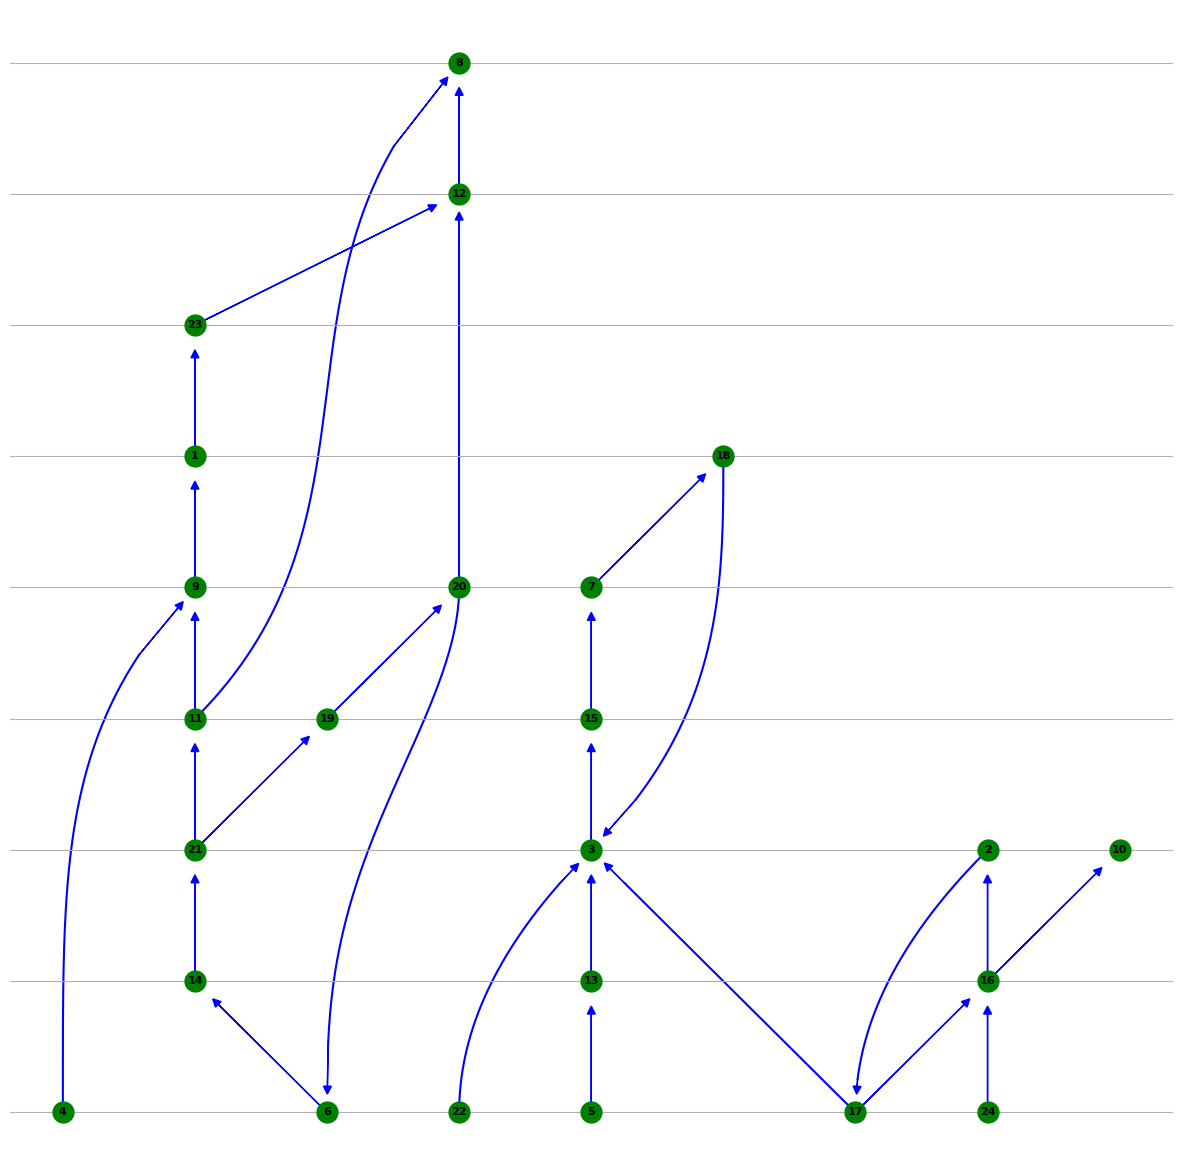

In [193]:
#FINAL OUTPUT
#edge_drawing_plot('Datasets/smallnet.dot',dif_color='blue',ite = 10000)

In [184]:
#edge_drawing_plot('smallnet.dot',heur='median',dif_color='blue')

### Pro League Network

Approach 1

In [185]:
# weights = get_data('Datasets/LeagueNetwork.dot')[-1]

# pos_weights = {edge:weight for edge,weight in weights.items() if int(weight)>0}
# pos_edges = list(pos_weights.keys())
# pos_nodes = list(set([node for edge in pos_edges for node in edge]))
# create_pydot_graph(pos_nodes,pos_edges,'XPos_LeagueNetwork.dot',pos_weights,dir=True)

# zero_weights = {edge:1 for edge,weight in weights.items() if int(weight)==0} #changed it to 1 so that we can apply marshal
# zero_edges = list(zero_weights.keys())
# zero_nodes = list(set([node for edge in zero_edges for node in edge]))
# create_pydot_graph(zero_nodes,zero_edges,'XZero_LeagueNetwork.dot',zero_weights,dir=True)

# neg_weights = {edge:abs(weight) for edge,weight in weights.items() if int(weight)<0}
# neg_edges = [(edge[1],edge[0]) for edge in list(neg_weights.keys())]
# neg_nodes = list(set([node for edge in neg_edges for node in edge]))
# create_pydot_graph(neg_nodes,neg_edges,'XNeg_LeagueNetwork.dot',neg_weights,dir=True)

# print('pos_edges',len(pos_edges))
# print('zero_edges',len(zero_edges))
# print('zero_edges',len(zero_edges))

Approach 2

In [186]:
# weights = get_data('Datasets/LeagueNetwork.dot')[-1]
# unique_weights = sorted(list(set(get_data('Datasets/LeagueNetwork.dot')[-1].values())))
# league_files = []
# for weight_i in unique_weights:
#     weights_i = {edge:weight for edge,weight in weights.items() if int(weight)==weight_i}
#     edges = list(weights_i.keys())
#     # for edge in edges:
#     #     if (edge[1],edge[0]) in edges:
#     #         edges.remove((edge[1],edge[0]))
#     #         del 
#     nodes = list(set([node for edge in edges for node in edge]))
#     file_name = str(str(weight_i)+'LeagueNetwork.dot')
#     league_files.append(file_name)
#     create_pydot_graph(nodes,edges,file_name,weights_i)

# # pos_weights = {edge:weight for edge,weight in weights.items() if int(weight)>0}
# pos_edges = list(pos_weights.keys())
# pos_nodes = list(set([node for edge in pos_edges for node in edge]))
# # file_name = str(str(weight)+'_LeagueNetwork.dot')
# create_pydot_graph(pos_nodes,pos_edges,file_name,{edge:weight for edge,weight in weights.items() if int(weight)>0})
# #create_pydot_graph(pos_nodes,pos_edges,'XPos_LeagueNetwork.dot',pos_weights)

### Jazz Network

In [187]:
#plot_layer_assignment('Datasets/JazzNetwork.dot')

In [188]:
#plot_cross_min('Datasets/LesMiserables.dot',heur='bary')